# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from matplotlib.colors import ListedColormap
%matplotlib inline

# **Importing Dataset**



In [3]:
# Load iris dataset
ds = tfds.load('iris', split='train', as_supervised=True)
data = [(f.numpy(), l.numpy()) for f, l in ds]

# Convert to DataFrame
df = pd.DataFrame(data, columns=['features', 'label'])
features_df = pd.DataFrame(df['features'].tolist(),
                           columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_df = pd.concat([features_df, df['label']], axis=1)

# Keep only 3 features for visualization and NN input
dataset = iris_df.drop(columns=['petal_width'])

# Check shape
print(dataset.shape)
print(dataset.head())

(150, 4)
   sepal_length  sepal_width  petal_length  label
0           5.1          3.4           1.5      0
1           7.7          3.0           6.1      2
2           5.7          2.8           4.5      1
3           6.8          3.2           5.9      2
4           5.2          3.4           1.4      0


In [4]:
# Check missing values
print(dataset.isnull().sum())

# Check duplicates
print("Duplicate rows:", dataset.duplicated().sum())

# Drop duplicates
dataset.drop_duplicates(keep='first', inplace=True)
print("After drop:", dataset.duplicated().sum())

sepal_length    0
sepal_width     0
petal_length    0
label           0
dtype: int64
Duplicate rows: 7
After drop: 0


In [18]:
# Take only 2 features: sepal_length and petal_length
dataset_two_features = dataset[['sepal_length', 'petal_length', 'label']]

# Extract features and labels
X = dataset_two_features.iloc[:, :-1].values
y = dataset_two_features.iloc[:, -1].values

# Label Encoding and One-hot encoding
labels, y_encoded = np.unique(y, return_inverse=True)
y_one_hot = np.eye(len(labels))[y_encoded]

print("Classes:", labels)
print("Feature shape:", X.shape)
print("Label shape (one-hot):", y_one_hot.shape)

Classes: [0 1 2]
Feature shape: (143, 2)
Label shape (one-hot): (143, 3)


In [19]:
print("Dataset shape:", X.shape)

indices = np.random.permutation(len(X))
split_ratio = 0.8
train_size = int(len(X) * split_ratio)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X[train_indices]
X_test = X[test_indices]
y_train = y_one_hot[train_indices]
y_test = y_one_hot[test_indices]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Dataset shape: (143, 2)
Train shape: (114, 2) (114, 3)
Test shape: (29, 2) (29, 3)


In [20]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 2
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 8
        hiddenLayer3Neurons = 6
        outputLayerNeurons = 3

        self.learning_rate = 0.2

        # Weight initialization
        self.W_H1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        self.h1_out = self.sigmoid(np.dot(X, self.W_H1))
        self.h2_out = self.sigmoid(np.dot(self.h1_out, self.W_H2))
        self.h3_out = self.sigmoid(np.dot(self.h2_out, self.W_H3))
        pred = self.sigmoid(np.dot(self.h3_out, self.W_O))
        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.sigmoid(pred, der=True)

        h3_error = output_delta.dot(self.W_O.T)
        h3_delta = self.learning_rate * h3_error * self.sigmoid(self.h3_out, der=True)

        h2_error = h3_delta.dot(self.W_H3.T)
        h2_delta = self.learning_rate * h2_error * self.sigmoid(self.h2_out, der=True)

        h1_error = h2_delta.dot(self.W_H2.T)
        h1_delta = self.learning_rate * h1_error * self.sigmoid(self.h1_out, der=True)

        # Update weights
        self.W_O += self.h3_out.T.dot(output_delta)
        self.W_H3 += self.h2_out.T.dot(h3_delta)
        self.W_H2 += self.h1_out.T.dot(h2_delta)
        self.W_H1 += X.T.dot(h1_delta)

    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)

In [21]:
def categorical_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

Epoch 0/10000 - Loss: 0.2307
Epoch 1000/10000 - Loss: 0.0412
Epoch 2000/10000 - Loss: 0.0345
Epoch 3000/10000 - Loss: 0.0322
Epoch 4000/10000 - Loss: 0.0309
Epoch 5000/10000 - Loss: 0.0298
Epoch 6000/10000 - Loss: 0.0281
Epoch 7000/10000 - Loss: 0.0275
Epoch 8000/10000 - Loss: 0.0271
Epoch 9000/10000 - Loss: 0.0267


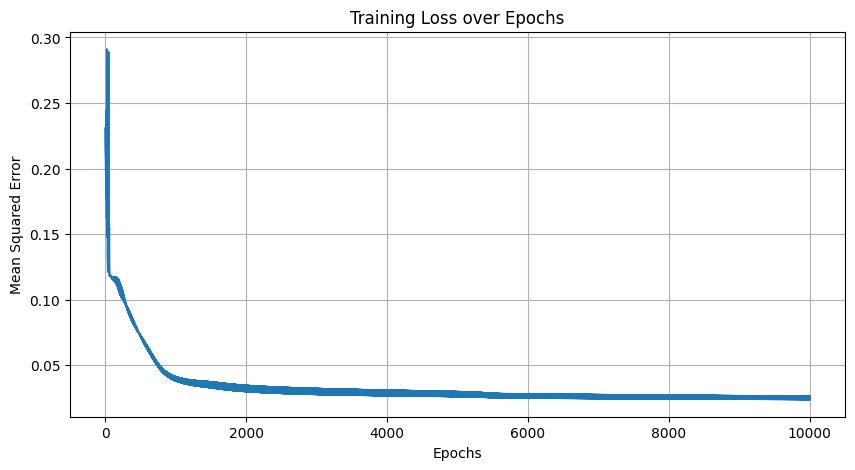

In [24]:
# Initialize the neural network
NN = NeuralNetwork()

# Store training loss
err = []

# Training loop
epochs = 10000
for i in range(epochs):
    NN.train(X_train, y_train)
    # Mean squared error for monitoring
    y_pred = NN.feedForward(X_train)
    err.append(np.mean(np.square(y_train - y_pred)))

    # Print progress every 1000 epochs
    if i % 1000 == 0:
        print(f"Epoch {i}/{epochs} - Loss: {err[-1]:.4f}")

# Plot training error
plt.figure(figsize=(10,5))
plt.plot(err)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()


In [25]:
# Predict on test data
y_test_pred = NN.feedForward(X_test)

# Compute test loss and accuracy
test_loss = np.mean(np.square(y_test - y_test_pred))  # Using same MSE as training
test_acc = accuracy(y_test, y_test_pred)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")

Test Loss: 0.0191
Test Accuracy: 96.55%


/tmp/ipython-input-4074138782.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_plot[y_plot == label, 0],
/tmp/ipython-input-4074138782.py:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_plot[y_plot == label, 0],


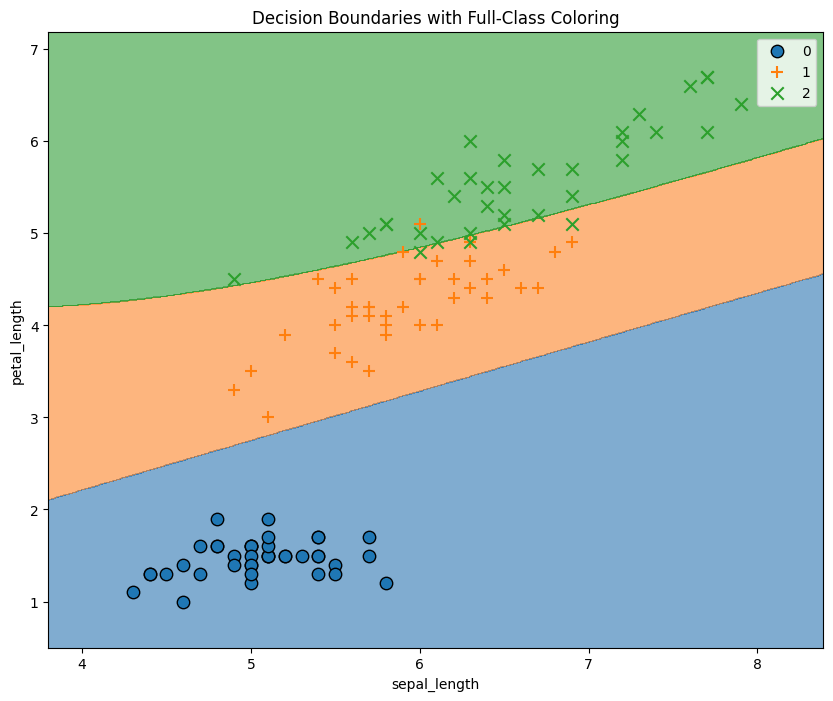

In [26]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Define markers
markers = ['o', '+', 'x']

# Use first two features for plotting
X_plot = X_train[:, :2]
y_plot = np.argmax(y_train, axis=1)

# Create mesh grid for background
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict class for each point in the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]  # only 2 features
Z = NN.feedForward(grid_points)
Z = np.argmax(Z, axis=1).reshape(xx.shape)

# Color map for classes
cmap = ListedColormap(['#2b75b1', '#fd8529', '#2f9d35'])

plt.figure(figsize=(10, 8))
# Background: fully colored class regions
plt.contourf(xx, yy, Z, alpha=0.6, cmap=cmap)

# Plot training points on top
for label, marker in zip(np.unique(y_plot), markers):
    plt.scatter(X_plot[y_plot == label, 0],
                X_plot[y_plot == label, 1],
                marker=marker,
                s=80,
                edgecolors='black',
                label=labels[label])

plt.xlabel("sepal_length")
plt.ylabel("petal_length")
plt.title("Decision Boundaries with Full-Class Coloring")
plt.legend()
plt.show()